# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project aims to apply Natural Language Processing (NLP) techniques to analyze the content of comments that are publicly available on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149) for this docket. For technical reasons (see the [Data_Prep notebook](./Data_Prep.ipynb)), the dataset only includes ~8K comments, which are the ones typed directly onto the site. The dataset excludes another ~3K comments submitted in an attachment form (most of which were PDFs).

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [119]:
import re
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
# from wordcloud import WordCloud

In [2]:
full_df = pd.read_pickle('./Data/full_df.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...


## Topic Analysis

In [67]:
# Process comment column for topic analysis

# Remove punctuation
full_df['Comment_processed'] = full_df['Comment'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
full_df['Comment_processed'] = full_df['Comment'].map(lambda x: x.lower())

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Comment_processed
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,i write to express my opposition to the enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,i write to express my opposition to the enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...","my husband and i have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,please do not change the definitions within th...


In [68]:
comments = full_df['Comment_processed']

comments.head()

0    i write to express my opposition to the enviro...
1    i write to express my opposition to the enviro...
2    please abandon this proposed rollback of the 2...
3    my husband and i have two wonderful daughters,...
4    please do not change the definitions within th...
Name: Comment_processed, dtype: object

In [70]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic-by-vocabulary orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [71]:
# Helper function to plot most common words
def plot_most_common_words(count_data, count_vect, n=10):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :return: None; plots a matplotlib.pyplot bar chart of top n words
    """
    import matplotlib.pyplot as plt
    
    words = count_vect.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('{} Most Common Words'.format(n))
    plt.show()


In [78]:
# Create matrix with word counts by comment
# TOKENS_ALPHANUM = '[A-Za-z0-9]+(?=\\s+)'

count_vec = CountVectorizer(stop_words='english')

count_data = count_vec.fit_transform(comments)
print(count_data.shape)

# Create array of vocabulary terms
vocab = np.array(count_vec.get_feature_names())

(8187, 22434)


In [80]:
s = 1100
print(vocab[s:s+100])

['abomination' 'abound' 'abounds' 'aboutepa' 'aboveground' 'aboveis' 'abq'
 'abraham' 'abrahams' 'abrahamson' 'abrams' 'abreast' 'abridge' 'abridged'
 'abroad' 'abrogated' 'abrogation' 'abrsorbing' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absolve' 'absorb' 'absorbed'
 'absorbing' 'absorbs' 'absorption' 'abstention' 'abstract' 'absurd'
 'absurdities' 'absurdity' 'absurdly' 'abudent' 'abudt' 'abundance'
 'abundant' 'abundent' 'abuse' 'abused' 'abuses' 'abusing' 'abusive'
 'abut' 'abuting' 'abuts' 'abutted' 'abutting' 'abysmal' 'academia'
 'academic' 'academically' 'academy' 'accelerate' 'accelerated'
 'accelerates' 'accelerating' 'accept' 'acceptability' 'acceptable'
 'acceptance' 'accepted' 'acceptible' 'accepting' 'accepts' 'access'
 'accesse' 'accessed' 'accessibility' 'accessible' 'accessing'
 'accheivment' 'accident' 'accidental' 'accidentally' 'accidents'
 'accolades' 'accomadate' 'accommodate' 'accommodating' 'accomodate'
 'accompanied' 'accompanies' 'accompany' 'ac

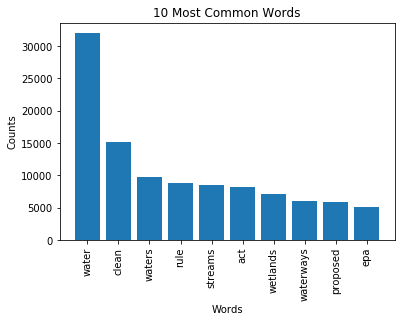

In [81]:
plot_most_common_words(count_data, count_vec)

### Singular Value Decomposition Analysis

In [82]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(count_data.todense(), full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(8187, 8187) (8187,) (8187, 22434)


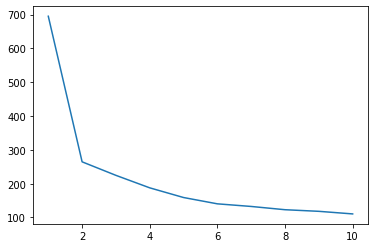

In [83]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);

In [84]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['rosamond torrance winthrop devan artem faillacetarrytown lunatic feeler',
 'water clean waterways families act proposal drinking gut',
 'epa states waters farmers definition support united land',
 'water clean dirty clear communities need polluters rule',
 'waters water states quality united protections wetlands park',
 'clean waterways rule dirty polluters protections waters communities',
 'waterways new adjacent categories quality ephemeral percent creeks',
 'states definition united dirty communities polluters epa important',
 'water definition wotus drinking epa bodies cwa protection',
 'epa corps wetlands proposal protection protections streams park']

Aside from the gibberish that comprises the first topic, the rest all seem reasonable with regards to the data.

### LDA

In [114]:
n_topics = 12

# Create and fit an LDA model
lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [115]:
lda.components_.shape

(12, 22434)

In [116]:
print('Final perplexity score: {0:,.0f}'.format(lda.bound_))

Final perplexity score: 995


In [117]:
show_topics(lda.components_, vocab)

['water rules clean rule farmers land clear support',
 'water clean act waterways streams proposal waters drinking',
 'waters definition wotus regulation property water states regards',
 'water rivers new streams industry creeks life pollute',
 'water wetlands waters rule proposed streams clean protection',
 'water waters states united definition act clean regulations',
 'water clean people life protect environment need future',
 'water clean waters protections wetlands streams act rule',
 'rule proposed water waters definition epa wotus support',
 'water streams wetlands clean rule downstream proposed waterways',
 'water clean rule communities waterways epa wetlands polluters',
 'regards comment write irrigation wheeler mr people idaho']

In [110]:
# Compare perplexity scores for various number of topics
p = []

for n in range(2, 19, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('----------------')

Number of Topics: 2
Perplexity score: 1,236
----------------
Number of Topics: 4
Perplexity score: 1,147
----------------
Number of Topics: 6
Perplexity score: 1,110
----------------
Number of Topics: 8
Perplexity score: 1,071
----------------
Number of Topics: 10
Perplexity score: 1,022
----------------
Number of Topics: 12
Perplexity score: 995
----------------
Number of Topics: 14
Perplexity score: 979
----------------
Number of Topics: 16
Perplexity score: 976
----------------
Number of Topics: 18
Perplexity score: 965
----------------


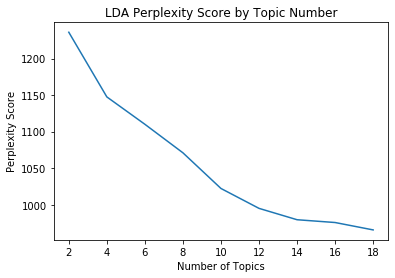

In [113]:
# Plot the perplexity scores
plt.plot(range(2, 19, 2), p);
plt.title('LDA Perplexity Score by Topic Number');
plt.ylabel('Perplexity Score');
plt.xlabel('Number of Topics');

The sharpest decline in perplexity score happens from two to four topics, with steady declines until 10-12 topics. After that point, the scores still drop but at an almost neglible rate.

## NMF

In [95]:
# Create and fit an NMF model
nmf = NMF(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [96]:
show_topics(H1, vocab)

['water clean act protections protect river life drinking',
 'water definition wetlands wotus drinking ephemeral surface intermittent',
 'streams wetlands downstream rule proposed flow small rivers',
 'water waterways act proposal streams waters families clean',
 'rule proposed waters epa wotus 2015 case support',
 'water farmers rules land rule epa clear new',
 'waterways rule proposed wetlands streams new waters categories',
 'water protections wetlands streams park quality parks waters',
 'waters states united wetlands protection act definition revised',
 'water clean rule communities epa dirty polluters waterways']